[2018-03-22 23:42:05.260070] INFO: system_log: rqdatac use socket ('q-rqdatad', 16003)
2016-03-07 WARN 订单被拒单: [J88] 已涨停。
2016-05-09 WARN 订单创建失败: 下单量为 0
/opt/conda/envs/ricequant/lib/python3.5/site-packages/rqalpha/utils/risk.py:122: RuntimeWarning: invalid value encountered in double_scalars
  self._beta = cov[0][1] / cov[1][1]


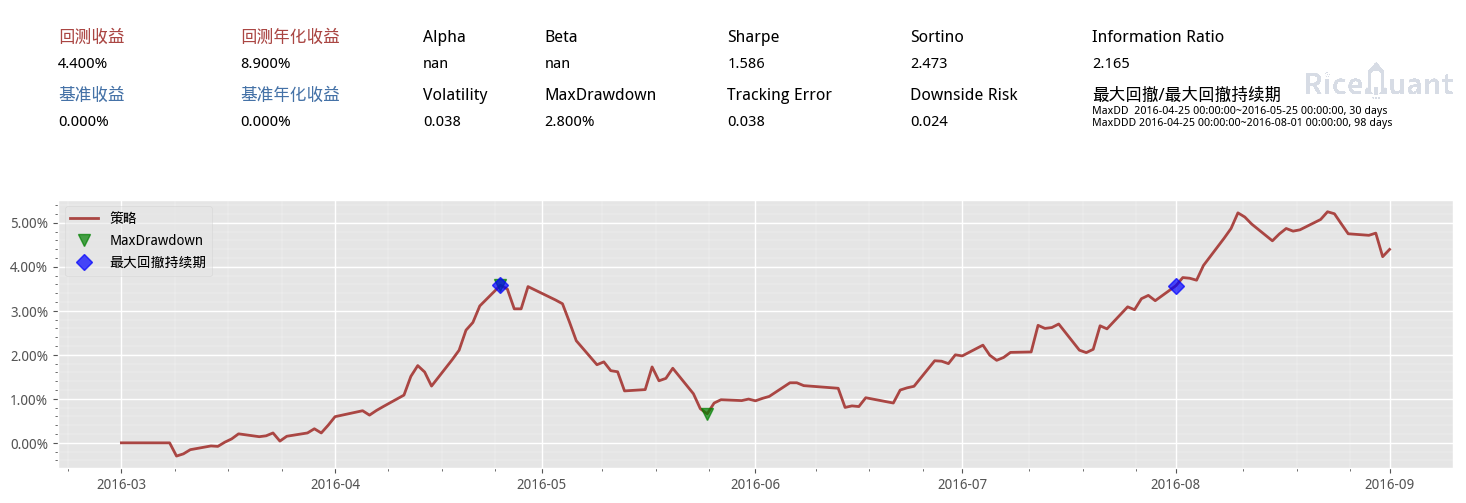

In [1]:
%%rqalpha_plus -s 20160301 -e 20160901 --account future 1000000 -fq 1d -p 
# 上述命令参数可以通过运行 %%rqalpha_plus -h 查看到
 
# 可以自己import我们平台支持的第三方python模块，比如pandas、numpy等。
import talib as tab
import pandas as pd
import numpy as np

# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    # context内引入全局变量s1
    context.s1 = "J88"
    context.AbsDisp = 5
    context.AvgLen = 20
    context.ExitBar = 5
    context.bar_counts = 0
    
    # 初始化时订阅合约行情。订阅之后的合约行情会在handle_bar中进行更新。
    subscribe(context.s1)
    # 实时打印日志
def check(context,bar_dict):
    # bar_dict[context.s1]
    bars = history_bars(context.s1,context.AbsDisp+context.AvgLen,'1d',['high','low','close'])
    high_ = bars['high']
    low_ = bars['low']
    
    ranges = high_-low_
    medians = (high_+low_)/2
    
    _pre_bar_high = high_[-2]
    _pre_bar_low = low_[-2]
    
    high_ma = tab.MA(high_[:-context.AbsDisp],context.AvgLen)[-1]
    low_ma = tab.MA(low_[:-context.AbsDisp],context.AvgLen)[-1]
    exitAvg = tab.MA(medians[:-context.AbsDisp],context.AvgLen)[-1]
    
    # 当k线中点大于前一根k线高点 并且振幅大于上一个振幅
    # print(medians[-1])
    # print(_pre_bar_high)
    # print(ranges)
    rangeLead_B = medians[-1]>_pre_bar_high and ranges[-1] > ranges[-2]
    # 当k线中点小于前一根k线低点 并且振幅大于上一个振幅
    rangeLead_S = medians[-1]<_pre_bar_low and ranges[-1] > ranges[-2]
    
    bqt = context.portfolio.positions[context.s1].buy_quantity
    sqt = context.portfolio.positions[context.s1].sell_quantity
    
    if bqt == 0 and sqt == 0:
        if rangeLead_B and bars['close'][-1] > high_ma:
            context.bar_counts = 1
            buyOpen(context)
        if rangeLead_S and bars['close'][-1] < low_ma:
            context.bar_counts = 1
            sellOpen(context)
    
    _bar_count = context.bar_counts
    if _bar_count>0 and bqt >0 :
        # 离场
        if _bar_count <= context.ExitBar :
            if low_[-1] <=exitAvg:
                context.bar_counts = 0
                sellClose(context)
        elif _bar_count >context.ExitBar:
            if low_[-1] <= high_ma-1:
                context.bar_counts = 0
                sellClose(context)
                
    if _bar_count>0 and sqt >0:
        if _bar_count <= context.ExitBar :
            if high_[-1] >=exitAvg:
                context.bar_counts = 0
                buyClose(context)
        elif _bar_count >context.ExitBar:
            if high_[-1] >= low_ma+1:
                context.bar_counts = 0
                buyClose(context)

# before_trading此函数会在每天策略交易开始前被调用，当天只会被调用一次
def before_trading(context):
    # check(context,bar_dict)
    pass

def buyOpen(context):
    buy_open(context.s1,1)
    
def sellOpen(context):
    sell_open(context.s1,1)

def buyClose(context):
    buy_close(context.s1,0)
    
def sellClose(context):
    sell_close(context.s1,0)
    


# 你选择的期货数据更新将会触发此段逻辑，例如日线或分钟线更新
def handle_bar(context, bar_dict):
    check(context,bar_dict)
    if context.bar_counts !=0:
        context.bar_counts +=1
    

# after_trading函数会在每天交易结束后被调用，当天只会被调用一次
def after_trading(context):
    pass